In [30]:
import requests
from bs4 import BeautifulSoup
import requests
from paperview.retrieval.biorxiv_api import (
    Article
)
from paperview.retrieval import pdf_extraction
from paperview.retrieval import process_xml
import tempfile
from io import StringIO
from PIL import Image
import seaborn as sns
import pandas as pd
from io import StringIO

import pdfplumber

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
url = 'https://www.biorxiv.org/content/10.1101/2022.07.21.500746v1'
# url = 'https://www.biorxiv.org/content/10.1101/456574v1'
# url = 'https://www.biorxiv.org/content/10.1101/2022.12.21.521407v1?rss=1'
# url = 'https://www.biorxiv.org/content/10.1101/2022.09.12.507457v1.full'
# url = 'https://www.biorxiv.org/content/10.1101/386375v1.full'
# url = 'https://www.biorxiv.org/content/10.1101/2022.07.20.500837v1?rss=1'
# url = 'https://www.biorxiv.org/content/10.1101/180125v2.full'
# url = 'https://www.biorxiv.org/content/10.1101/2022.06.26.497672v3?rss=1'
# url = 'https://www.biorxiv.org/content/10.1101/2023.01.10.523450v1?rss=1'


In [74]:
article = Article.from_content_page_url(
    url, 
    prog_bar=True, 
    extract_images=True)

100%|██████████| 36/36 [00:19<00:00,  1.83it/s]


In [76]:
article.article_detail.pdf_url

'https://www.biorxiv.org/content/10.1101/2022.07.21.500746v1.full.pdf'

In [68]:
article.data['figure_captions']

,section,id,caption,label,xref_id
0,Graphical abstract,2.2.2,,,ufig1
1,Materials and Methods,3.2.2.2,Five hundred and eighty-six dogs were screened...,Fig. 1,fig1
2,Materials and Methods,3.2.6.8,DAG (directed acyclic graph) represents the me...,Fig. 2,fig2
3,Results,3.3.2.2.2,Canine frailty index scores in the different a...,Fig. 3,fig3
4,Results,3.3.2.3.2,Canine frailty index (CFI) scores in the diffe...,Fig. 4,fig4
5,Results,3.3.3.2.2,a. Total Health related quality of life (HRQL)...,Fig. 5,fig5
6,Results,3.3.3.3.2,a. Total Health Related Quality of Life (HRQL)...,Fig. 6,fig6
7,Results,3.3.4.2,a. Scatter plots of total Health Related Quali...,Fig. 7,fig7
8,Results,3.3.5.2,The most common Canine Frailty Index (CFI) Fea...,Fig. 8,fig8


In [73]:
article.data['images']

[{'x0': 91.93898,
  'y0': 396.0,
  'x1': 450.92208,
  'y1': 638.9134,
  'width': 358.9831,
  'height': 242.91340000000002,
  'name': 'Im0',
  'stream': <PDFStream(1449): raw=10560, {'BitsPerComponent': 8, 'ColorSpace': <PDFObjRef:1434>, 'Filter': /'DCTDecode', 'Height': 293, 'Interpolate': True, 'Length': 10560, 'Subtype': /'Image', 'Type': /'XObject', 'Width': 433}>,
  'srcsize': (433, 293),
  'imagemask': None,
  'bits': 8,
  'colorspace': [[/'ICCBased',
    <PDFStream(1459): raw=2612, {'Alternate': /'DeviceRGB', 'Filter': /'FlateDecode', 'Length': 2612, 'N': 3}>]],
  'object_type': 'image',
  'page_number': 30,
  'top': 153.08659999999998,
  'bottom': 396.0,
  'doctop': 24575.3366,
  'image': <PIL.Image.Image image mode=RGB size=1495x1013>,
  'image_number': 1},
 {'x0': 4.418307,
  'y0': 207.0098,
  'x1': 571.581707,
  'y1': 632.3823,
  'width': 567.1634,
  'height': 425.37249999999995,
  'name': 'Im0',
  'stream': <PDFStream(1450): raw=171483, {'BitsPerComponent': 8, 'ColorSpace': 

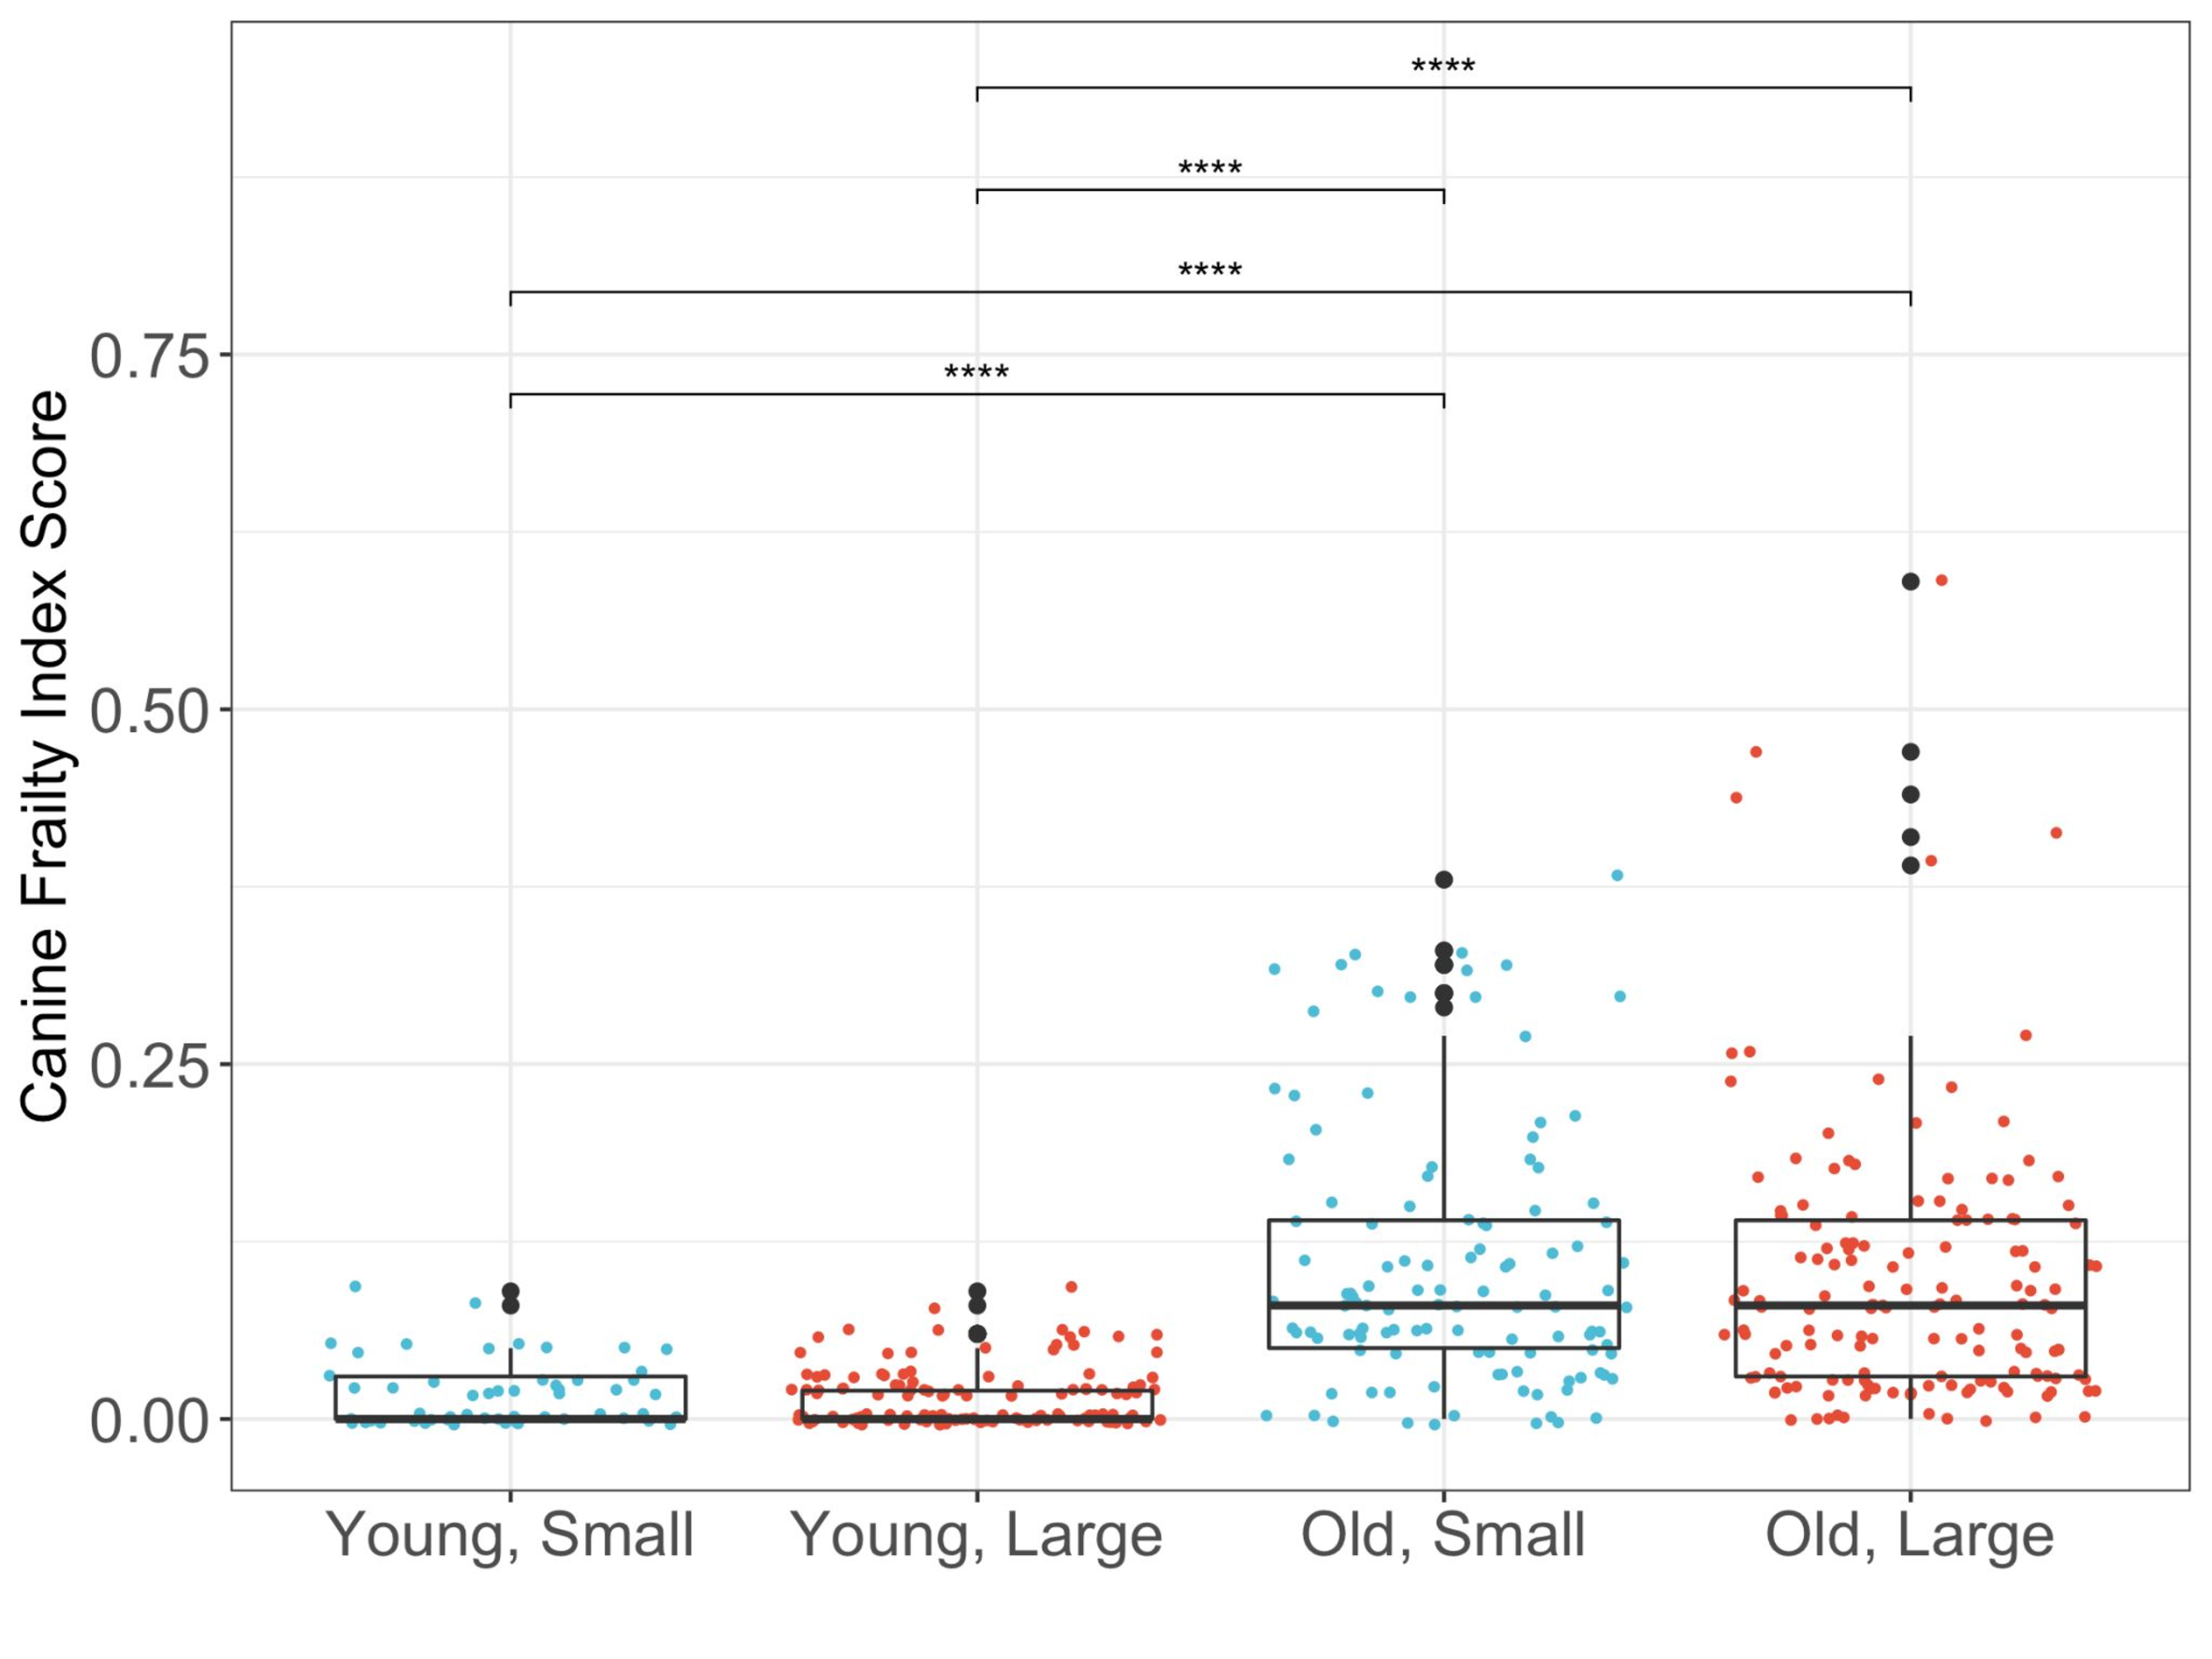

In [72]:
article.data['images'][1]['image']

In [62]:
article.data['text']

[]

In [59]:
article.get_overview().display()

TypeError: function takes at most 13 arguments (14 given)

In [ ]:
article.article_detail

In [78]:
xmlstr = article.article_detail.retrieve_jats_xml()

In [90]:
text = process_xml.xmlstr_to_dict(xmlstr)
df = pd.DataFrame(text['body_sections'])
sections = df.query('level == 2').set_index('title')['id'].to_dict()
texts = []
figures = []
tables = []
for sec_title, sec_id in sections.items():
    subsection_idx = df.id.str.startswith(sec_id)
    subsections = df.loc[subsection_idx]
    
    for subsec_id, subsection in subsections.set_index('id').iterrows():
        contents = subsection['contents']
        for content in contents:
            if content.get('tag') == 'p':
                texts.append({
                    'section': sec_title,
                    'id': content['id'],
                    'text': content['text']
                })
            elif content.get('tag') == 'fig':
                
                figures.append({
                    'section': sec_title,
                    'id': content['id'],
                    'caption': content['caption'],
                    'label': content['label'],
                    'xref_id': content.get('xref_id')
                })
                dodo = content
            elif content.get('tag') == 'table':
                tables.append({
                    'section': sec_title,
                    'id': content['id'],
                    'caption': content['caption'],
                    'label': content['label'],
                    'xref_id': content.get('xref_id')
                })

texts = pd.DataFrame(texts)
figures = pd.DataFrame(figures)
tables = pd.DataFrame(tables)

In [96]:
figures

,section,id,caption,label,xref_id
0,Graphical abstract,2.2.2,,,ufig1
1,Materials and Methods,3.2.2.2,Five hundred and eighty-six dogs were screened...,Fig. 1,fig1
2,Materials and Methods,3.2.6.8,DAG (directed acyclic graph) represents the me...,Fig. 2,fig2
3,Results,3.3.2.2.2,Canine frailty index scores in the different a...,Fig. 3,fig3
4,Results,3.3.2.3.2,Canine frailty index (CFI) scores in the diffe...,Fig. 4,fig4
5,Results,3.3.3.2.2,a. Total Health related quality of life (HRQL)...,Fig. 5,fig5
6,Results,3.3.3.3.2,a. Total Health Related Quality of Life (HRQL)...,Fig. 6,fig6
7,Results,3.3.4.2,a. Scatter plots of total Health Related Quali...,Fig. 7,fig7
8,Results,3.3.5.2,The most common Canine Frailty Index (CFI) Fea...,Fig. 8,fig8


In [95]:
# use lxml to open xmlstr
from lxml import etree
root = etree.fromstring(xmlstr)

In [100]:
# find element with label = Fig. 1
label = 'Fig. 1'


In [125]:
f'https://www.biorxiv.org/content/{self.doi}v{self.version}.full.pdf'

In [133]:

base_xml_url = article.article_detail.jatsxml.split('.source.xml')[0]

In [136]:
f'{base_xml_url}/{slug}.large.jpg'

# get image from url
from urllib.request import urlopen
from io import BytesIO
from PIL import Image

url = f'{base_xml_url}/{slug}.large.jpg'
with urlopen(url) as response:
    with BytesIO(response.read()) as file:
        img = Image.open(file)
        img.show()


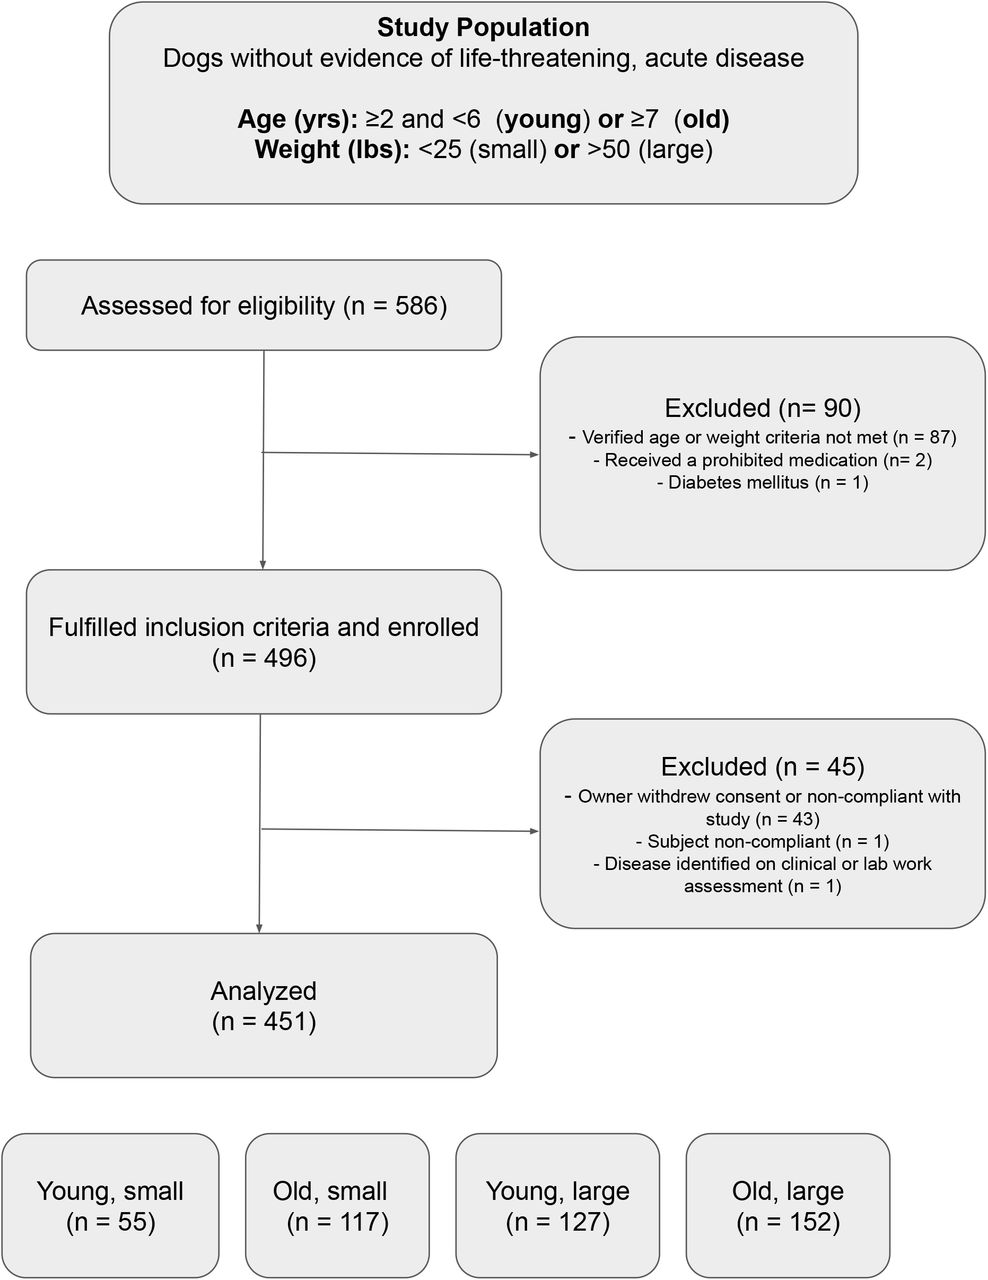

In [137]:
img

In [72]:
sections

{'Graphical abstract': '2.2',
 'Introduction': '3.1',
 'Materials and Methods': '3.2',
 'Results': '3.3',
 'Discussion': '3.4',
 'Conclusion': '3.5',
 'Supporting information': '3.6'}

In [35]:
df.loc['3.3.2.1', 'contents']

[{'tag': 'p',
  'text': 'The distribution of CFI scores was wider in old dogs compared to young dogs. The distribution of the CFI scores in each age-size group was non-normal with positive skew. CFI scores in the evaluable population of dogs (n = 450) ranged from 0.0 to 0.59, with a median of 0.03, and IQR of 0.09. IQRs of CFI scores in old dog groups were larger than that of young dog groups (Table 3).',
  'id': '3.3.2.1.1'},
 {'tag': 'table',
  'xref_id': 'tbl3',
  'xref_url': 'https://www.ncbi.nlm.nih.gov/pmc/articles//table/tbl3',
  'label': 'Table 3',
  'caption': 'Canine Frailty Index (CFI) and Health Related Quality of Life (HRQL) Scores across age-size groups with mean, standard deviation, interquartile range, range (minimum, maximum), and p-values for Kruskal-Wallis Tests showing significant differences across age-size groups',
  'footer': '',
  'media': [],
  'graphics': ['500746v1_tbl3', '500746v1_tbl3a'],
  'table_columns': [],
  'table_values': [],
  'xml': '',
  'id': '3.

In [25]:
df.loc[2, 'contents']

[{'tag': 'p',
  'text': 'Graphical summary of the design, results, and conclusions of the study.',
  'id': '2.2.1'},
 {'tag': 'fig',
  'caption': '',
  'xref_url': 'https://www.ncbi.nlm.nih.gov/pmc/articles//figure/ufig1',
  'xref_id': 'ufig1',
  'label': '',
  'media': [],
  'graphics': ['500746v1_ufig1'],
  'pmcid': '',
  'id': '2.2.2'}]